# Statistical Analysis - Titans Finance Transaction Dataset

This notebook conducts comprehensive statistical analysis of transaction patterns, including normality tests, correlation analysis, hypothesis testing, time series analysis, and trend detection.

## Statistical Objectives:
- Test data distributions and normality assumptions
- Conduct correlation analysis between variables
- Perform hypothesis testing for pattern validation
- Analyze time series patterns and seasonality
- Detect trends and statistical relationships

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import (
    normaltest, shapiro, anderson, kstest, 
    pearsonr, spearmanr, chi2_contingency,
    ttest_ind, mannwhitneyu, kruskal
)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

# Configure visualization
plt.style.use('default')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (14, 8)
pd.set_option('display.max_columns', None)

# Set random seed for reproducibility
np.random.seed(42)

## 1. Data Preparation and Initial Setup

In [5]:
# Load and prepare data
df = pd.read_csv('../../data/all_transactions.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Create derived features for statistical analysis
df['Amount_Abs'] = df['Amount'].abs()
df['Amount_Log'] = np.log1p(df['Amount_Abs'])
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
df['DaysFromStart'] = (df['Date'] - df['Date'].min()).dt.days

# Separate income and expenses
income_df = df[df['Type'] == 'Income'].copy()
expense_df = df[df['Type'] == 'Expense'].copy()

print(f"Dataset loaded: {len(df)} transactions")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Income transactions: {len(income_df)}")
print(f"Expense transactions: {len(expense_df)}")

# Display basic statistics
print("\nBasic Statistics:")
print(df[['Amount', 'Amount_Abs', 'Amount_Log']].describe())

Dataset loaded: 124 transactions
Date range: 2024-12-06 00:00:00 to 2025-07-29 00:00:00
Income transactions: 15
Expense transactions: 109

Basic Statistics:
             Amount    Amount_Abs  Amount_Log
count    124.000000    124.000000  124.000000
mean     539.513790   1194.795565    5.015479
std     2903.547502   2699.053031    1.962466
min   -14115.000000      8.790000    2.281361
25%     -154.447500     30.255000    3.442053
50%      -55.815000     82.160000    4.420532
75%      -22.622500    403.637500    6.002936
max     9040.000000  14115.000000    9.555064


## 2. Normality Testing

In [6]:
def comprehensive_normality_test(data, name):
    """Perform comprehensive normality testing"""
    print(f"\n{'='*50}")
    print(f"NORMALITY TESTS FOR {name.upper()}")
    print(f"{'='*50}")
    
    # Remove any infinite or NaN values
    clean_data = data[np.isfinite(data)]
    n = len(clean_data)
    
    if n < 8:
        print(f"Insufficient data points: {n}")
        return
    
    # Shapiro-Wilk test (best for small samples)
    if n <= 5000:
        shapiro_stat, shapiro_p = shapiro(clean_data)
        print(f"Shapiro-Wilk Test:")
        print(f"  Statistic: {shapiro_stat:.4f}")
        print(f"  P-value: {shapiro_p:.6f}")
        print(f"  Normal: {'Yes' if shapiro_p > 0.05 else 'No'}")
    
    # D'Agostino's normality test
    if n >= 20:
        dagostino_stat, dagostino_p = normaltest(clean_data)
        print(f"\nD'Agostino's Normality Test:")
        print(f"  Statistic: {dagostino_stat:.4f}")
        print(f"  P-value: {dagostino_p:.6f}")
        print(f"  Normal: {'Yes' if dagostino_p > 0.05 else 'No'}")
    
    # Anderson-Darling test
    ad_result = anderson(clean_data, dist='norm')
    print(f"\nAnderson-Darling Test:")
    print(f"  Statistic: {ad_result.statistic:.4f}")
    print(f"  Critical Values: {ad_result.critical_values}")
    print(f"  Significance Levels: {ad_result.significance_level}")
    normal_ad = ad_result.statistic < ad_result.critical_values[2]  # 5% significance level
    print(f"  Normal (5% level): {'Yes' if normal_ad else 'No'}")
    
    # Kolmogorov-Smirnov test
    ks_stat, ks_p = kstest(clean_data, 'norm', args=(clean_data.mean(), clean_data.std()))
    print(f"\nKolmogorov-Smirnov Test:")
    print(f"  Statistic: {ks_stat:.4f}")
    print(f"  P-value: {ks_p:.6f}")
    print(f"  Normal: {'Yes' if ks_p > 0.05 else 'No'}")
    
    # Calculate skewness and kurtosis
    skewness = stats.skew(clean_data)
    kurtosis = stats.kurtosis(clean_data)
    
    print(f"\nDistribution Properties:")
    print(f"  Skewness: {skewness:.4f} ({'Right-skewed' if skewness > 0 else 'Left-skewed' if skewness < 0 else 'Symmetric'})")
    print(f"  Kurtosis: {kurtosis:.4f} ({'Heavy-tailed' if kurtosis > 0 else 'Light-tailed' if kurtosis < 0 else 'Normal-tailed'})")
    
    return {
        'n': n,
        'skewness': skewness,
        'kurtosis': kurtosis,
        'shapiro_p': shapiro_p if n <= 5000 else None,
        'dagostino_p': dagostino_p if n >= 20 else None,
        'anderson_normal': normal_ad,
        'ks_p': ks_p
    }

# Test normality for different variables
amount_results = comprehensive_normality_test(df['Amount'], 'Transaction Amounts')
amount_abs_results = comprehensive_normality_test(df['Amount_Abs'], 'Absolute Amounts')
amount_log_results = comprehensive_normality_test(df['Amount_Log'], 'Log-transformed Amounts')

# Test normality for income and expense amounts separately
if len(income_df) > 8:
    income_results = comprehensive_normality_test(income_df['Amount'], 'Income Amounts')
if len(expense_df) > 8:
    expense_results = comprehensive_normality_test(expense_df['Amount_Abs'], 'Expense Amounts (Absolute)')


NORMALITY TESTS FOR TRANSACTION AMOUNTS
Shapiro-Wilk Test:
  Statistic: 0.5443
  P-value: 0.000000
  Normal: No

D'Agostino's Normality Test:
  Statistic: 39.6146
  P-value: 0.000000
  Normal: No

Anderson-Darling Test:
  Statistic: 26.0479
  Critical Values: [0.559 0.637 0.764 0.891 1.06 ]
  Significance Levels: [15.  10.   5.   2.5  1. ]
  Normal (5% level): No

Kolmogorov-Smirnov Test:
  Statistic: 0.4539
  P-value: 0.000000
  Normal: No

Distribution Properties:
  Skewness: 0.7546 (Right-skewed)
  Kurtosis: 7.5922 (Heavy-tailed)

NORMALITY TESTS FOR ABSOLUTE AMOUNTS
Shapiro-Wilk Test:
  Statistic: 0.4907
  P-value: 0.000000
  Normal: No

D'Agostino's Normality Test:
  Statistic: 84.9029
  P-value: 0.000000
  Normal: No

Anderson-Darling Test:
  Statistic: 27.9726
  Critical Values: [0.559 0.637 0.764 0.891 1.06 ]
  Significance Levels: [15.  10.   5.   2.5  1. ]
  Normal (5% level): No

Kolmogorov-Smirnov Test:
  Statistic: 0.3801
  P-value: 0.000000
  Normal: No

Distribution Pro

In [ ]:
# Visualize distributions and normality
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Row 1: Histograms
axes[0, 0].hist(df['Amount'], bins=30, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribution of Transaction Amounts')
axes[0, 0].set_xlabel('Amount')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(df['Amount_Abs'], bins=30, alpha=0.7, edgecolor='black', color='orange')
axes[0, 1].set_title('Distribution of Absolute Amounts')
axes[0, 1].set_xlabel('Absolute Amount')
axes[0, 1].set_ylabel('Frequency')

axes[0, 2].hist(df['Amount_Log'], bins=30, alpha=0.7, edgecolor='black', color='green')
axes[0, 2].set_title('Distribution of Log-transformed Amounts')
axes[0, 2].set_xlabel('Log(1 + Amount)')
axes[0, 2].set_ylabel('Frequency')

# Row 2: Q-Q plots
stats.probplot(df['Amount'], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot: Transaction Amounts')

stats.probplot(df['Amount_Abs'], dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot: Absolute Amounts')

stats.probplot(df['Amount_Log'], dist="norm", plot=axes[1, 2])
axes[1, 2].set_title('Q-Q Plot: Log-transformed Amounts')

# Row 3: Box plots
axes[2, 0].boxplot(df['Amount'])
axes[2, 0].set_title('Box Plot: Transaction Amounts')
axes[2, 0].set_ylabel('Amount')

axes[2, 1].boxplot(df['Amount_Abs'])
axes[2, 1].set_title('Box Plot: Absolute Amounts')
axes[2, 1].set_ylabel('Absolute Amount')

axes[2, 2].boxplot(df['Amount_Log'])
axes[2, 2].set_title('Box Plot: Log-transformed Amounts')
axes[2, 2].set_ylabel('Log(1 + Amount)')

plt.tight_layout()
plt.show()

## 3. Correlation Analysis

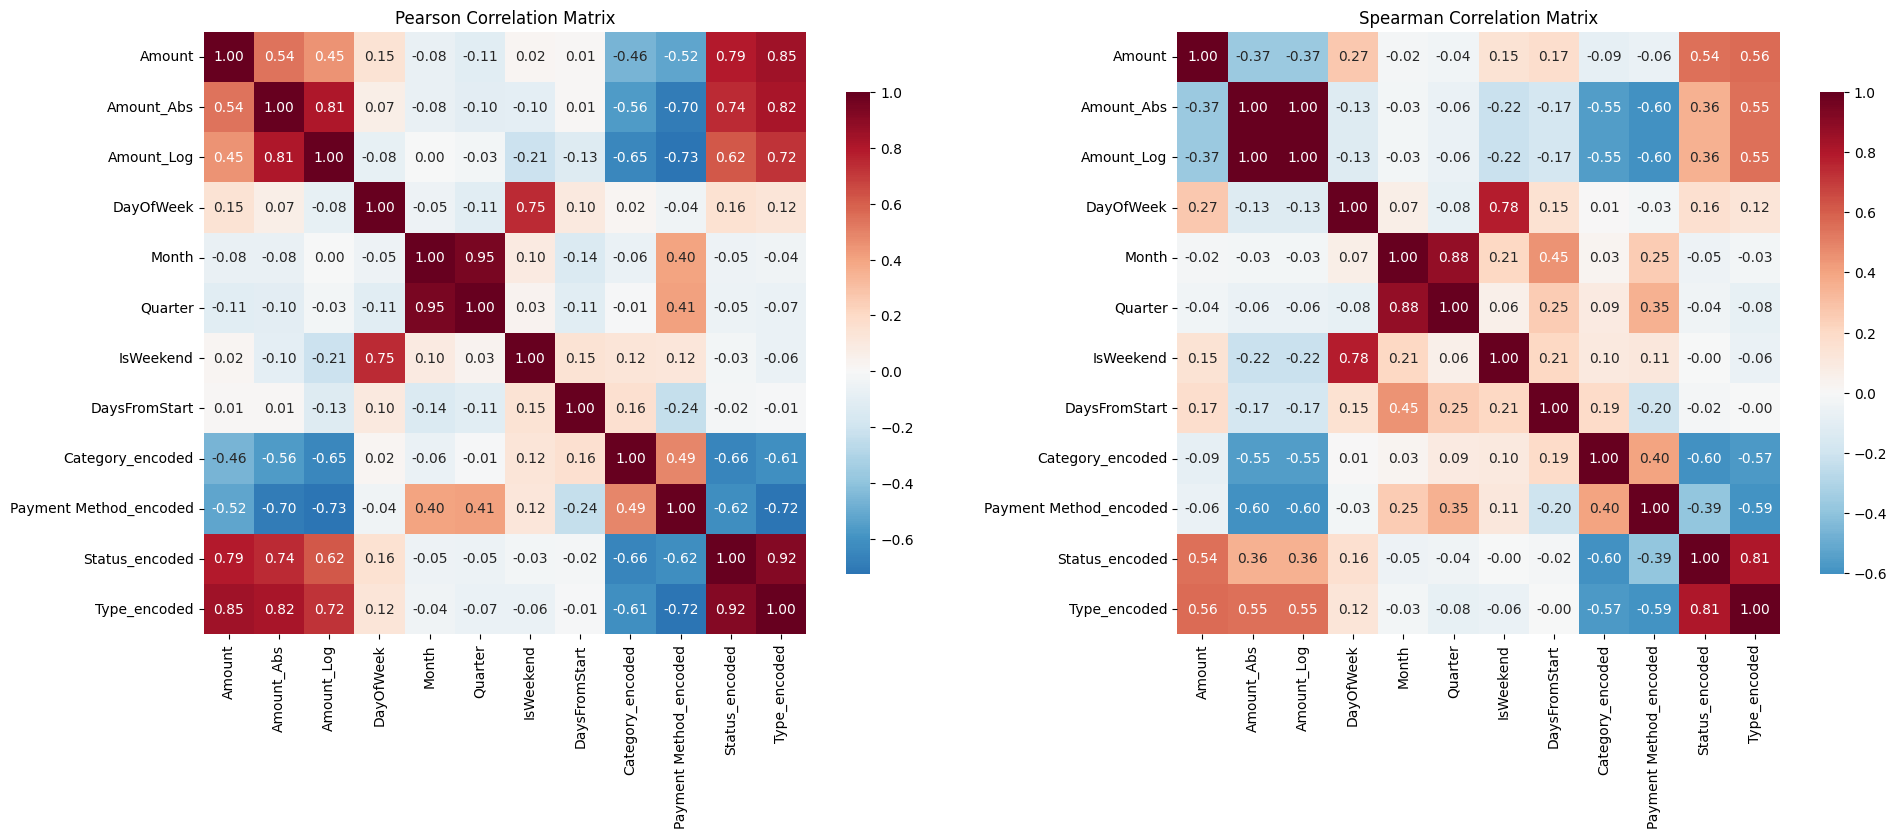


🔍 CORRELATION ANALYSIS RESULTS
Strong Pearson Correlations (|r| > 0.3):
  Month <-> Quarter: 0.953
  Status_encoded <-> Type_encoded: 0.917
  Amount <-> Type_encoded: 0.850
  Amount_Abs <-> Type_encoded: 0.824
  Amount_Abs <-> Amount_Log: 0.806
  Amount <-> Status_encoded: 0.792
  DayOfWeek <-> IsWeekend: 0.747
  Amount_Abs <-> Status_encoded: 0.743
  Amount_Log <-> Payment Method_encoded: -0.727
  Payment Method_encoded <-> Type_encoded: -0.723
  Amount_Log <-> Type_encoded: 0.723
  Amount_Abs <-> Payment Method_encoded: -0.696
  Category_encoded <-> Status_encoded: -0.659
  Amount_Log <-> Category_encoded: -0.650
  Payment Method_encoded <-> Status_encoded: -0.617
  Amount_Log <-> Status_encoded: 0.616
  Category_encoded <-> Type_encoded: -0.609
  Amount_Abs <-> Category_encoded: -0.565
  Amount <-> Amount_Abs: 0.541
  Amount <-> Payment Method_encoded: -0.522
  Category_encoded <-> Payment Method_encoded: 0.490
  Amount <-> Category_encoded: -0.459
  Amount <-> Amount_Log: 0.450
  

In [7]:
# Encode categorical variables for correlation analysis
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
categorical_columns = ['Category', 'Payment Method', 'Status', 'Type']

for col in categorical_columns:
    le = LabelEncoder()
    df_encoded[f'{col}_encoded'] = le.fit_transform(df_encoded[col].fillna('Unknown'))

# Select numerical variables for correlation analysis
numerical_vars = [
    'Amount', 'Amount_Abs', 'Amount_Log',
    'DayOfWeek', 'Month', 'Quarter', 'IsWeekend', 'DaysFromStart',
    'Category_encoded', 'Payment Method_encoded', 'Status_encoded', 'Type_encoded'
]

# Calculate correlation matrices
pearson_corr = df_encoded[numerical_vars].corr(method='pearson')
spearman_corr = df_encoded[numerical_vars].corr(method='spearman')

# Display correlation matrices
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Pearson correlation
sns.heatmap(pearson_corr, annot=True, cmap='RdBu_r', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8}, ax=axes[0])
axes[0].set_title('Pearson Correlation Matrix')

# Spearman correlation
sns.heatmap(spearman_corr, annot=True, cmap='RdBu_r', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8}, ax=axes[1])
axes[1].set_title('Spearman Correlation Matrix')

plt.tight_layout()
plt.show()

print("\n🔍 CORRELATION ANALYSIS RESULTS")
print("=" * 50)

# Find strong correlations
def find_strong_correlations(corr_matrix, threshold=0.3, correlation_type="Pearson"):
    strong_corrs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > threshold:
                strong_corrs.append((
                    corr_matrix.columns[i], 
                    corr_matrix.columns[j], 
                    corr_val
                ))
    return sorted(strong_corrs, key=lambda x: abs(x[2]), reverse=True)

strong_pearson = find_strong_correlations(pearson_corr, 0.3, "Pearson")
strong_spearman = find_strong_correlations(spearman_corr, 0.3, "Spearman")

print(f"Strong Pearson Correlations (|r| > 0.3):")
for var1, var2, corr in strong_pearson:
    print(f"  {var1} <-> {var2}: {corr:.3f}")

print(f"\nStrong Spearman Correlations (|ρ| > 0.3):")
for var1, var2, corr in strong_spearman:
    print(f"  {var1} <-> {var2}: {corr:.3f}")

In [8]:
# Detailed correlation analysis with significance testing
def correlation_with_significance(x, y, method='pearson'):
    """Calculate correlation with significance test"""
    if method == 'pearson':
        corr, p_value = pearsonr(x, y)
    elif method == 'spearman':
        corr, p_value = spearmanr(x, y)
    return corr, p_value

print("\n📊 DETAILED CORRELATION ANALYSIS WITH SIGNIFICANCE")
print("=" * 60)

# Key relationships to test
key_relationships = [
    ('Amount_Abs', 'DayOfWeek', 'Amount vs Day of Week'),
    ('Amount_Abs', 'Month', 'Amount vs Month'),
    ('Amount_Abs', 'IsWeekend', 'Amount vs Weekend'),
    ('Amount_Abs', 'DaysFromStart', 'Amount vs Time Trend'),
    ('DayOfWeek', 'Month', 'Day of Week vs Month'),
]

for var1, var2, description in key_relationships:
    # Remove NaN values
    data1 = df_encoded[var1].dropna()
    data2 = df_encoded[var2].dropna()
    common_idx = data1.index.intersection(data2.index)
    
    if len(common_idx) > 5:
        x = data1[common_idx]
        y = data2[common_idx]
        
        pearson_r, pearson_p = correlation_with_significance(x, y, 'pearson')
        spearman_r, spearman_p = correlation_with_significance(x, y, 'spearman')
        
        print(f"\n{description}:")
        print(f"  Pearson:  r = {pearson_r:6.3f}, p = {pearson_p:.6f} {'*' if pearson_p < 0.05 else ''}")
        print(f"  Spearman: ρ = {spearman_r:6.3f}, p = {spearman_p:.6f} {'*' if spearman_p < 0.05 else ''}")
        print(f"  Interpretation: {'Significant' if min(pearson_p, spearman_p) < 0.05 else 'Not significant'}")


📊 DETAILED CORRELATION ANALYSIS WITH SIGNIFICANCE

Amount vs Day of Week:
  Pearson:  r =  0.068, p = 0.454688 
  Spearman: ρ = -0.129, p = 0.154108 
  Interpretation: Not significant

Amount vs Month:
  Pearson:  r = -0.076, p = 0.400476 
  Spearman: ρ = -0.026, p = 0.773466 
  Interpretation: Not significant

Amount vs Weekend:
  Pearson:  r = -0.098, p = 0.280461 
  Spearman: ρ = -0.218, p = 0.014899 *
  Interpretation: Significant

Amount vs Time Trend:
  Pearson:  r =  0.008, p = 0.925651 
  Spearman: ρ = -0.173, p = 0.054535 
  Interpretation: Not significant

Day of Week vs Month:
  Pearson:  r = -0.049, p = 0.589866 
  Spearman: ρ =  0.069, p = 0.446426 
  Interpretation: Not significant


## 4. Hypothesis Testing

In [9]:
print("\n🧪 HYPOTHESIS TESTING")
print("=" * 50)

# Test 1: Are weekend transactions different from weekday transactions?
weekday_amounts = df[df['IsWeekend'] == 0]['Amount_Abs']
weekend_amounts = df[df['IsWeekend'] == 1]['Amount_Abs']

if len(weekday_amounts) > 3 and len(weekend_amounts) > 3:
    # T-test (assuming unequal variances)
    t_stat, t_p = ttest_ind(weekend_amounts, weekday_amounts, equal_var=False)
    # Mann-Whitney U test (non-parametric)
    u_stat, u_p = mannwhitneyu(weekend_amounts, weekday_amounts, alternative='two-sided')
    
    print("\nHypothesis Test 1: Weekend vs Weekday Transaction Amounts")
    print(f"H0: Weekend and weekday amounts are equal")
    print(f"H1: Weekend and weekday amounts are different")
    print(f"\nSample sizes: Weekend = {len(weekend_amounts)}, Weekday = {len(weekday_amounts)}")
    print(f"Weekend mean: ${weekend_amounts.mean():.2f}")
    print(f"Weekday mean: ${weekday_amounts.mean():.2f}")
    print(f"\nWelch's t-test: t = {t_stat:.3f}, p = {t_p:.6f}")
    print(f"Mann-Whitney U: U = {u_stat:.0f}, p = {u_p:.6f}")
    print(f"Conclusion: {'Reject H0' if min(t_p, u_p) < 0.05 else 'Fail to reject H0'} (α = 0.05)")

# Test 2: Are there differences in amounts across transaction types?
if len(income_df) > 3 and len(expense_df) > 3:
    income_amounts = income_df['Amount']
    expense_amounts = expense_df['Amount_Abs']
    
    t_stat2, t_p2 = ttest_ind(income_amounts, expense_amounts, equal_var=False)
    u_stat2, u_p2 = mannwhitneyu(income_amounts, expense_amounts, alternative='two-sided')
    
    print("\n\nHypothesis Test 2: Income vs Expense Transaction Amounts")
    print(f"H0: Income and expense amounts are equal")
    print(f"H1: Income and expense amounts are different")
    print(f"\nSample sizes: Income = {len(income_amounts)}, Expense = {len(expense_amounts)}")
    print(f"Income mean: ${income_amounts.mean():.2f}")
    print(f"Expense mean: ${expense_amounts.mean():.2f}")
    print(f"\nWelch's t-test: t = {t_stat2:.3f}, p = {t_p2:.6f}")
    print(f"Mann-Whitney U: U = {u_stat2:.0f}, p = {u_p2:.6f}")
    print(f"Conclusion: {'Reject H0' if min(t_p2, u_p2) < 0.05 else 'Fail to reject H0'} (α = 0.05)")

# Test 3: Are amounts different across payment methods? (ANOVA/Kruskal-Wallis)
payment_groups = [group['Amount_Abs'].values for name, group in df.groupby('Payment Method') if len(group) > 2]
payment_names = [name for name, group in df.groupby('Payment Method') if len(group) > 2]

if len(payment_groups) > 2:
    # Kruskal-Wallis test (non-parametric ANOVA)
    kw_stat, kw_p = kruskal(*payment_groups)
    
    print("\n\nHypothesis Test 3: Amounts Across Payment Methods")
    print(f"H0: All payment method amounts have the same distribution")
    print(f"H1: At least one payment method has different amounts")
    print(f"\nPayment methods tested: {', '.join(payment_names)}")
    print(f"Sample sizes: {[len(group) for group in payment_groups]}")
    print(f"\nKruskal-Wallis test: H = {kw_stat:.3f}, p = {kw_p:.6f}")
    print(f"Conclusion: {'Reject H0' if kw_p < 0.05 else 'Fail to reject H0'} (α = 0.05)")


🧪 HYPOTHESIS TESTING

Hypothesis Test 1: Weekend vs Weekday Transaction Amounts
H0: Weekend and weekday amounts are equal
H1: Weekend and weekday amounts are different

Sample sizes: Weekend = 34, Weekday = 90
Weekend mean: $767.59
Weekday mean: $1356.19

Welch's t-test: t = -1.205, p = 0.232091
Mann-Whitney U: U = 1098, p = 0.015632
Conclusion: Reject H0 (α = 0.05)


Hypothesis Test 2: Income vs Expense Transaction Amounts
H0: Income and expense amounts are equal
H1: Income and expense amounts are different

Sample sizes: Income = 15, Expense = 109
Income mean: $7168.48
Expense mean: $372.73

Welch's t-test: t = 11.735, p = 0.000000
Mann-Whitney U: U = 1619, p = 0.000000
Conclusion: Reject H0 (α = 0.05)


Hypothesis Test 3: Amounts Across Payment Methods
H0: All payment method amounts have the same distribution
H1: At least one payment method has different amounts

Payment methods tested: bank_transfer, credit_card, debit_card, loan
Sample sizes: [12, 45, 41, 11]

Kruskal-Wallis test

In [10]:
# Chi-square test for independence
print("\n\nHypothesis Test 4: Independence Tests")
print("=" * 40)

# Test independence between transaction type and payment method
contingency_type_payment = pd.crosstab(df['Type'], df['Payment Method'])
if contingency_type_payment.size > 0 and contingency_type_payment.min().min() >= 5:
    chi2_stat, chi2_p, dof, expected = chi2_contingency(contingency_type_payment)
    
    print("\nTransaction Type vs Payment Method Independence:")
    print(f"H0: Type and Payment Method are independent")
    print(f"H1: Type and Payment Method are dependent")
    print(f"\nContingency Table:")
    print(contingency_type_payment)
    print(f"\nChi-square test: χ² = {chi2_stat:.3f}, p = {chi2_p:.6f}, df = {dof}")
    print(f"Conclusion: {'Reject H0' if chi2_p < 0.05 else 'Fail to reject H0'} (α = 0.05)")
else:
    print("\nInsufficient data for chi-square test (expected frequencies < 5)")

# Test independence between day of week and transaction type
df['DayName'] = df['Date'].dt.day_name()
contingency_day_type = pd.crosstab(df['DayName'], df['Type'])
if contingency_day_type.size > 0:
    chi2_stat2, chi2_p2, dof2, expected2 = chi2_contingency(contingency_day_type)
    
    print("\n\nDay of Week vs Transaction Type Independence:")
    print(f"H0: Day of week and transaction type are independent")
    print(f"H1: Day of week and transaction type are dependent")
    print(f"\nContingency Table:")
    print(contingency_day_type)
    print(f"\nChi-square test: χ² = {chi2_stat2:.3f}, p = {chi2_p2:.6f}, df = {dof2}")
    print(f"Conclusion: {'Reject H0' if chi2_p2 < 0.05 else 'Fail to reject H0'} (α = 0.05)")



Hypothesis Test 4: Independence Tests

Transaction Type vs Payment Method Independence:
H0: Type and Payment Method are independent
H1: Type and Payment Method are dependent

Contingency Table:
Payment Method  bank_transfer  credit_card  debit_card  loan
Type                                                        
Expense                    12           45          41    11

Chi-square test: χ² = 0.000, p = 1.000000, df = 0
Conclusion: Fail to reject H0 (α = 0.05)


Day of Week vs Transaction Type Independence:
H0: Day of week and transaction type are independent
H1: Day of week and transaction type are dependent

Contingency Table:
Type       Expense  Income
DayName                   
Friday          20       9
Monday          10       0
Saturday        14       2
Sunday          17       1
Thursday        20       2
Tuesday         14       1
Wednesday       14       0

Chi-square test: χ² = 14.413, p = 0.025345, df = 6
Conclusion: Reject H0 (α = 0.05)


## 5. Time Series Analysis

In [11]:
# Create daily time series
daily_transactions = df.groupby('Date').agg({
    'Amount': 'sum',
    'Amount_Abs': ['sum', 'count', 'mean']
}).reset_index()
daily_transactions.columns = ['Date', 'Net_Amount', 'Total_Abs_Amount', 'Transaction_Count', 'Avg_Amount']
daily_transactions.set_index('Date', inplace=True)

# Fill missing dates with zero values
date_range = pd.date_range(start=daily_transactions.index.min(), 
                          end=daily_transactions.index.max(), 
                          freq='D')
daily_transactions = daily_transactions.reindex(date_range, fill_value=0)

print("\n📈 TIME SERIES ANALYSIS")
print("=" * 40)
print(f"Time series length: {len(daily_transactions)} days")
print(f"Non-zero transaction days: {(daily_transactions['Transaction_Count'] > 0).sum()}")
print(f"Zero transaction days: {(daily_transactions['Transaction_Count'] == 0).sum()}")

# Stationarity tests
def test_stationarity(timeseries, title):
    print(f"\nStationarity Tests for {title}:")
    print("-" * 40)
    
    # Augmented Dickey-Fuller test
    adf_result = adfuller(timeseries.dropna())
    print(f"ADF Statistic: {adf_result[0]:.6f}")
    print(f"p-value: {adf_result[1]:.6f}")
    print(f"Critical Values:")
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value:.3f}")
    
    if adf_result[1] <= 0.05:
        print("Series is stationary (reject unit root hypothesis)")
    else:
        print("Series is non-stationary (fail to reject unit root hypothesis)")
    
    # KPSS test
    try:
        kpss_result = kpss(timeseries.dropna(), regression='c')
        print(f"\nKPSS Statistic: {kpss_result[0]:.6f}")
        print(f"p-value: {kpss_result[1]:.6f}")
        if kpss_result[1] >= 0.05:
            print("Series is stationary (fail to reject stationarity hypothesis)")
        else:
            print("Series is non-stationary (reject stationarity hypothesis)")
    except Exception as e:
        print(f"KPSS test failed: {e}")

# Test stationarity for different series
if len(daily_transactions) > 10:
    test_stationarity(daily_transactions['Net_Amount'], 'Daily Net Amount')
    test_stationarity(daily_transactions['Transaction_Count'], 'Daily Transaction Count')
    
    # Test for transaction count series (non-zero values only)
    non_zero_counts = daily_transactions[daily_transactions['Transaction_Count'] > 0]['Transaction_Count']
    if len(non_zero_counts) > 10:
        test_stationarity(non_zero_counts, 'Non-zero Daily Transaction Count')


📈 TIME SERIES ANALYSIS
Time series length: 236 days
Non-zero transaction days: 73
Zero transaction days: 163

Stationarity Tests for Daily Net Amount:
----------------------------------------
ADF Statistic: -11.468169
p-value: 0.000000
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.573
Series is stationary (reject unit root hypothesis)

KPSS Statistic: 0.064568
p-value: 0.100000
Series is stationary (fail to reject stationarity hypothesis)

Stationarity Tests for Daily Transaction Count:
----------------------------------------
ADF Statistic: -3.857960
p-value: 0.002367
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574
Series is stationary (reject unit root hypothesis)

KPSS Statistic: 0.350553
p-value: 0.098469
Series is stationary (fail to reject stationarity hypothesis)

Stationarity Tests for Non-zero Daily Transaction Count:
----------------------------------------
ADF Statistic: -7.335100
p-value: 0.000000
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589
Series is st

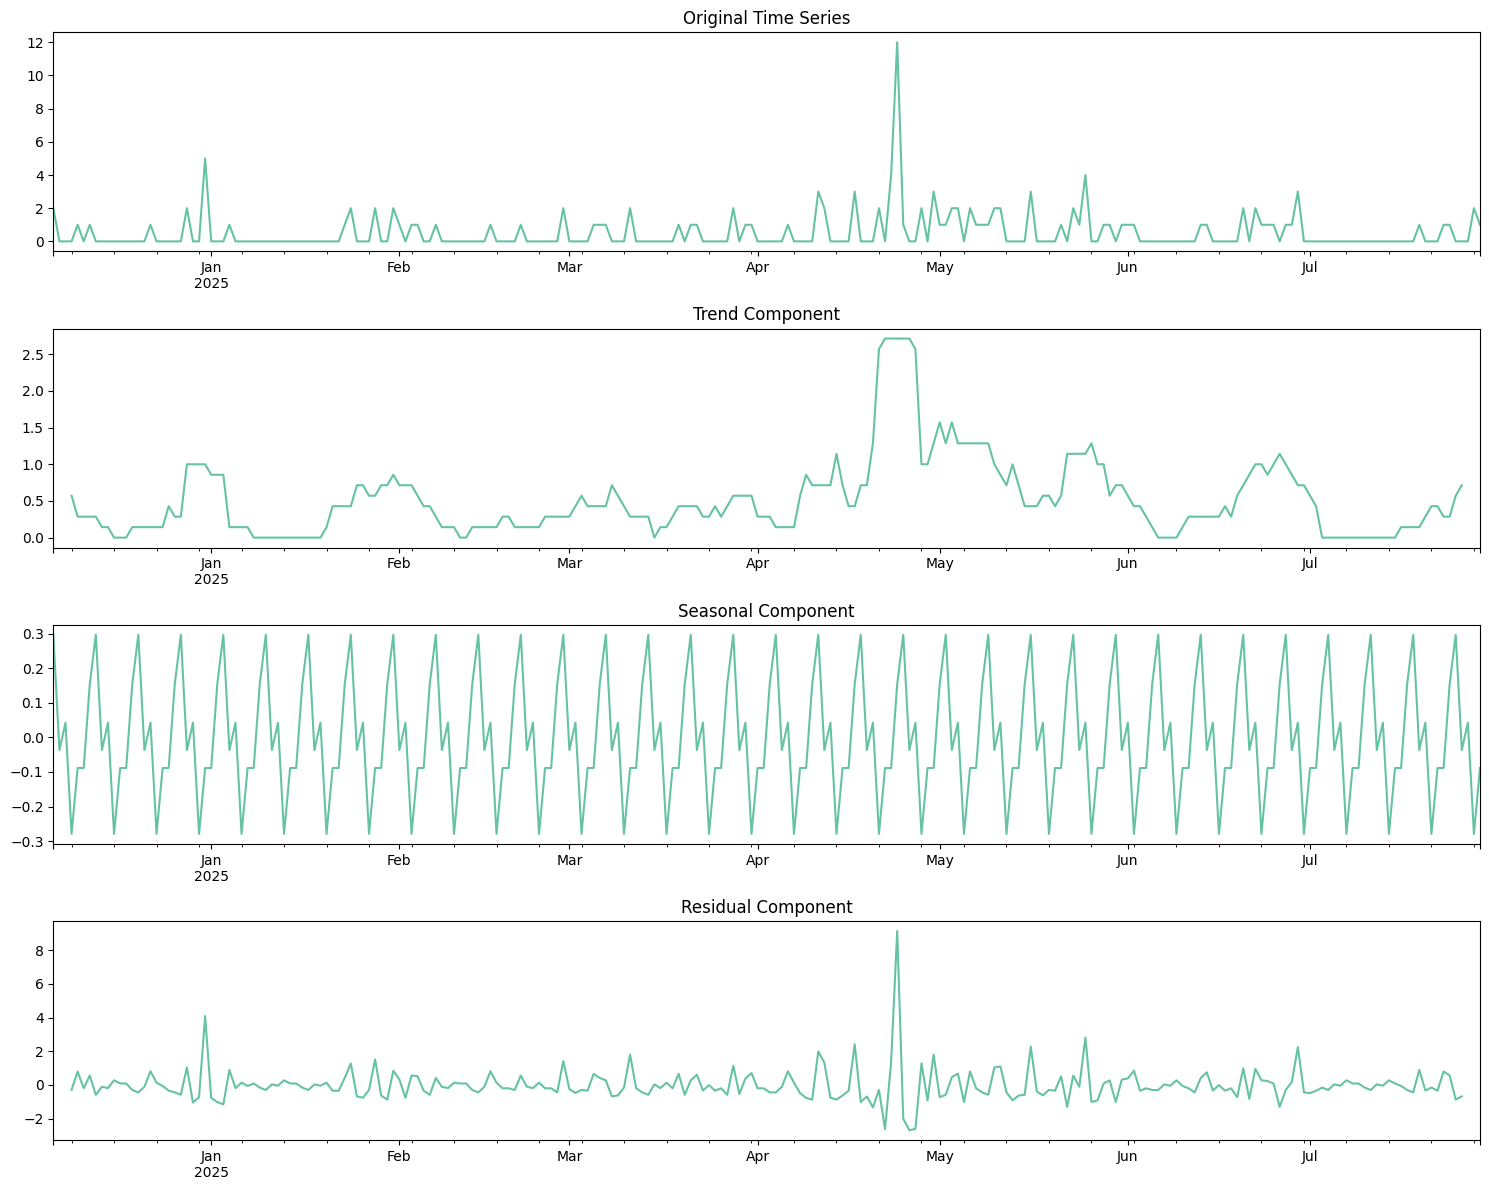


Ljung-Box test for residual randomness:
Seasonal decomposition failed: Unknown format code 'f' for object of type 'str'
This might be due to insufficient data or irregular patterns.


In [12]:
# Seasonal decomposition (if we have enough data)
if len(daily_transactions) >= 14:  # Need at least 2 weeks for weekly seasonality
    try:
        # Use transaction count for decomposition (more stable than amounts)
        decomposition = seasonal_decompose(daily_transactions['Transaction_Count'], 
                                         model='additive', period=7)  # Weekly seasonality
        
        fig, axes = plt.subplots(4, 1, figsize=(15, 12))
        
        decomposition.observed.plot(ax=axes[0], title='Original Time Series')
        decomposition.trend.plot(ax=axes[1], title='Trend Component')
        decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component')
        decomposition.resid.plot(ax=axes[3], title='Residual Component')
        
        plt.tight_layout()
        plt.show()
        
        # Test residuals for randomness
        residuals = decomposition.resid.dropna()
        if len(residuals) > 5:
            lb_stat, lb_p = acorr_ljungbox(residuals, lags=min(10, len(residuals)//4), return_df=False)
            print(f"\nLjung-Box test for residual randomness:")
            print(f"Statistic: {lb_stat[-1]:.6f}")
            print(f"p-value: {lb_p[-1]:.6f}")
            print(f"Residuals are {'random' if lb_p[-1] > 0.05 else 'not random'} (α = 0.05)")
        
    except Exception as e:
        print(f"Seasonal decomposition failed: {e}")
        print("This might be due to insufficient data or irregular patterns.")
else:
    print("\nInsufficient data for seasonal decomposition (need at least 14 days)")

## 6. Trend Analysis


📊 TREND ANALYSIS

Daily Net Amount:
  Slope: 0.890049 per day
  R-squared: 0.000773
  p-value: 0.670943
  Trend: Not significant

Daily Total Amount:
  Slope: 1.742461 per day
  R-squared: 0.003059
  p-value: 0.397641
  Trend: Not significant

Daily Transaction Count:
  Slope: 0.001334 per day
  R-squared: 0.006393
  p-value: 0.221065
  Trend: Not significant

Daily Average Amount:
  Slope: 0.429565 per day
  R-squared: 0.000079
  p-value: 0.940401
  Trend: Not significant


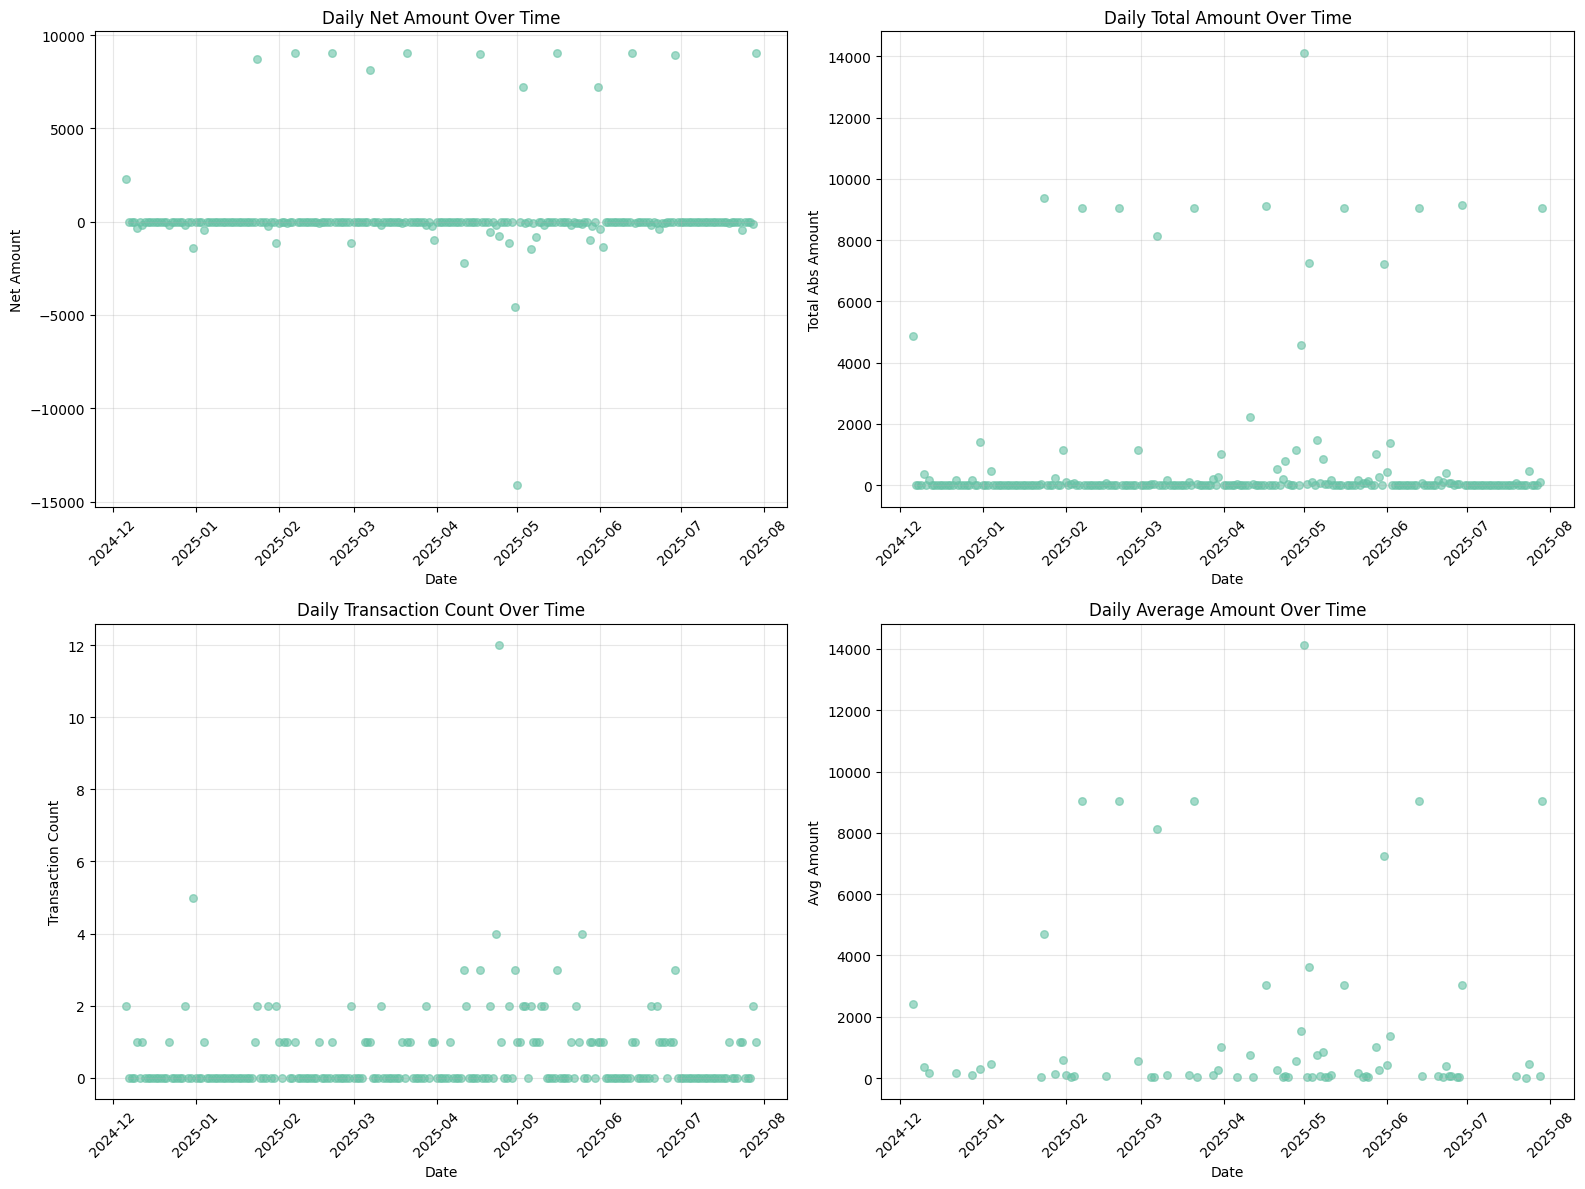

In [13]:
print("\n📊 TREND ANALYSIS")
print("=" * 30)

# Linear trend analysis using regression
from scipy.stats import linregress

# Analyze trends for different metrics
trend_variables = {
    'Net_Amount': 'Daily Net Amount',
    'Total_Abs_Amount': 'Daily Total Amount',
    'Transaction_Count': 'Daily Transaction Count',
    'Avg_Amount': 'Daily Average Amount'
}

# Create numeric time variable (days since start)
daily_transactions['Days'] = range(len(daily_transactions))

for var, description in trend_variables.items():
    # Filter out zero values for average amount
    if var == 'Avg_Amount':
        mask = daily_transactions[var] > 0
        y_data = daily_transactions.loc[mask, var]
        x_data = daily_transactions.loc[mask, 'Days']
    else:
        y_data = daily_transactions[var]
        x_data = daily_transactions['Days']
    
    if len(y_data) > 5:
        slope, intercept, r_value, p_value, std_err = linregress(x_data, y_data)
        
        print(f"\n{description}:")
        print(f"  Slope: {slope:.6f} per day")
        print(f"  R-squared: {r_value**2:.6f}")
        print(f"  p-value: {p_value:.6f}")
        print(f"  Trend: {'Significant' if p_value < 0.05 else 'Not significant'}")
        if p_value < 0.05:
            direction = 'increasing' if slope > 0 else 'decreasing'
            print(f"  Direction: {direction}")

# Visualize trends
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, (var, description) in enumerate(trend_variables.items()):
    if var == 'Avg_Amount':
        mask = daily_transactions[var] > 0
        y_data = daily_transactions.loc[mask, var]
        x_data = daily_transactions.loc[mask, 'Days']
        dates = daily_transactions.index[mask]
    else:
        y_data = daily_transactions[var]
        x_data = daily_transactions['Days']
        dates = daily_transactions.index
    
    axes[i].scatter(dates, y_data, alpha=0.6, s=30)
    
    # Add trend line if significant
    if len(y_data) > 5:
        slope, intercept, r_value, p_value, std_err = linregress(x_data, y_data)
        if p_value < 0.05:
            trend_line = slope * x_data + intercept
            axes[i].plot(dates, trend_line, 'r-', linewidth=2, 
                        label=f'Trend (p={p_value:.3f})')
            axes[i].legend()
    
    axes[i].set_title(f'{description} Over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(var.replace('_', ' '))
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Statistical Summary and Insights

In [14]:
print("\n📋 STATISTICAL ANALYSIS SUMMARY")
print("=" * 60)

print("\n🎯 KEY STATISTICAL FINDINGS:")
print("-" * 30)

# Normality findings
print("\n1. DISTRIBUTION CHARACTERISTICS:")
if amount_results:
    print(f"   • Transaction amounts: Skewness = {amount_results['skewness']:.2f}")
    print(f"   • Distribution shape: {'Right-skewed' if amount_results['skewness'] > 0.5 else 'Left-skewed' if amount_results['skewness'] < -0.5 else 'Approximately symmetric'}")
    if amount_results.get('shapiro_p'):
        normality = 'Normal' if amount_results['shapiro_p'] > 0.05 else 'Non-normal'
        print(f"   • Normality: {normality} (Shapiro p={amount_results['shapiro_p']:.6f})")
    
    if amount_log_results:
        log_normality = 'Normal' if amount_log_results.get('shapiro_p', 0) > 0.05 else 'Non-normal'
        print(f"   • Log-transformation improves normality: {log_normality}")

# Correlation findings
print("\n2. CORRELATION INSIGHTS:")
if strong_pearson:
    print(f"   • Strongest correlation: {strong_pearson[0][0]} <-> {strong_pearson[0][1]} (r={strong_pearson[0][2]:.3f})")
    print(f"   • Number of strong correlations (|r| > 0.3): {len(strong_pearson)}")
else:
    print("   • No strong linear correlations found (|r| > 0.3)")

# Hypothesis test findings
print("\n3. HYPOTHESIS TEST RESULTS:")
test_results = []
if 'weekend_amounts' in locals() and len(weekend_amounts) > 3:
    weekend_different = min(t_p, u_p) < 0.05
    test_results.append(f"Weekend vs Weekday amounts: {'Different' if weekend_different else 'No difference'} (p={min(t_p, u_p):.3f})")

if 'income_amounts' in locals() and len(income_amounts) > 3:
    type_different = min(t_p2, u_p2) < 0.05
    test_results.append(f"Income vs Expense amounts: {'Different' if type_different else 'No difference'} (p={min(t_p2, u_p2):.3f})")

if 'payment_groups' in locals() and len(payment_groups) > 2:
    payment_different = kw_p < 0.05
    test_results.append(f"Payment method amounts: {'Different' if payment_different else 'No difference'} (p={kw_p:.3f})")

for result in test_results:
    print(f"   • {result}")

# Time series findings
print("\n4. TIME SERIES CHARACTERISTICS:")
print(f"   • Data span: {len(daily_transactions)} days")
print(f"   • Active transaction days: {(daily_transactions['Transaction_Count'] > 0).sum()}/{len(daily_transactions)}")
activity_rate = (daily_transactions['Transaction_Count'] > 0).sum() / len(daily_transactions) * 100
print(f"   • Activity rate: {activity_rate:.1f}%")

# Generate recommendations
print("\n💡 STATISTICAL MODELING RECOMMENDATIONS:")
print("-" * 45)

recommendations = []

# Distribution recommendations
if amount_results and amount_results['skewness'] > 1.0:
    recommendations.append("Use log transformation for amount variables due to high skewness")
if amount_results and amount_results.get('shapiro_p', 0) < 0.05:
    recommendations.append("Use non-parametric methods due to non-normal distributions")

# Correlation recommendations
if len(strong_pearson) > 5:
    recommendations.append("Consider dimensionality reduction due to multiple correlations")
elif len(strong_pearson) == 0:
    recommendations.append("Variables appear independent - suitable for various ML models")

# Time series recommendations
if activity_rate < 50:
    recommendations.append("Handle sparse time series with zero-inflated models")
if len(daily_transactions) < 30:
    recommendations.append("Limited time series data - focus on cross-sectional analysis")

# Sample size recommendations
if len(df) < 100:
    recommendations.append("Small sample size - use bootstrap methods for robust estimation")
elif len(df) > 1000:
    recommendations.append("Large sample size suitable for complex models")

for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

if not recommendations:
    print("1. Dataset characteristics are suitable for standard statistical modeling")
    print("2. Both parametric and non-parametric methods can be applied")

print("\n🔬 SUGGESTED NEXT STEPS:")
print("-" * 25)
print("1. Feature engineering based on correlation insights")
print("2. Model selection considering distribution characteristics")
print("3. Cross-validation strategy accounting for time dependencies")
print("4. Outlier handling based on statistical tests")
print("5. Transform variables to improve model assumptions")

print("\n" + "=" * 60)
print("Statistical Analysis Complete")
print("=" * 60)


📋 STATISTICAL ANALYSIS SUMMARY

🎯 KEY STATISTICAL FINDINGS:
------------------------------

1. DISTRIBUTION CHARACTERISTICS:
   • Transaction amounts: Skewness = 0.75
   • Distribution shape: Right-skewed
   • Normality: Non-normal (Shapiro p=0.000000)
   • Log-transformation improves normality: Non-normal

2. CORRELATION INSIGHTS:
   • Strongest correlation: Month <-> Quarter (r=0.953)
   • Number of strong correlations (|r| > 0.3): 25

3. HYPOTHESIS TEST RESULTS:
   • Weekend vs Weekday amounts: Different (p=0.016)
   • Income vs Expense amounts: Different (p=0.000)
   • Payment method amounts: Different (p=0.000)

4. TIME SERIES CHARACTERISTICS:
   • Data span: 236 days
   • Active transaction days: 73/236
   • Activity rate: 30.9%

💡 STATISTICAL MODELING RECOMMENDATIONS:
---------------------------------------------
1. Use non-parametric methods due to non-normal distributions
2. Consider dimensionality reduction due to multiple correlations
3. Handle sparse time series with zero-

In [15]:
# Save statistical analysis results
statistical_results = {
    'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset_info': {
        'total_transactions': len(df),
        'date_range': f"{df['Date'].min()} to {df['Date'].max()}",
        'time_span_days': (df['Date'].max() - df['Date'].min()).days
    },
    'normality_tests': {
        'amount_skewness': float(amount_results['skewness']) if amount_results else None,
        'amount_kurtosis': float(amount_results['kurtosis']) if amount_results else None,
        'amount_normal': bool(amount_results.get('shapiro_p', 0) > 0.05) if amount_results else None,
        'log_transform_recommended': bool(amount_results and amount_results['skewness'] > 1.0)
    },
    'correlations': {
        'strong_correlations_count': len(strong_pearson),
        'strongest_correlation': {
            'variables': f"{strong_pearson[0][0]} <-> {strong_pearson[0][1]}",
            'correlation': float(strong_pearson[0][2])
        } if strong_pearson else None
    },
    'hypothesis_tests': {
        'weekend_weekday_different': bool(locals().get('t_p', 1) < 0.05) if 'weekend_amounts' in locals() else None,
        'income_expense_different': bool(locals().get('t_p2', 1) < 0.05) if 'income_amounts' in locals() else None,
        'payment_methods_different': bool(locals().get('kw_p', 1) < 0.05) if 'payment_groups' in locals() else None
    },
    'time_series': {
        'daily_observations': len(daily_transactions),
        'active_days': int((daily_transactions['Transaction_Count'] > 0).sum()),
        'activity_rate': float(activity_rate)
    },
    'recommendations': recommendations
}

import json
with open('../../data/statistical_analysis_results.json', 'w') as f:
    json.dump(statistical_results, f, indent=2, default=str)
print("Statistical analysis results saved to: data/statistical_analysis_results.json")

# Save daily time series data
daily_transactions.to_csv('../../data/daily_time_series.csv')
print("Daily time series data saved to: data/daily_time_series.csv")

Statistical analysis results saved to: data/statistical_analysis_results.json
Daily time series data saved to: data/daily_time_series.csv
